In [1]:
import wradlib as wrl
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import metpy
import requests
import matplotlib.pyplot as pl
import matplotlib.patheffects as pe
import matplotlib.colors
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from metpy.plots import ctables
from osgeo import osr
from wradlib.io.xarray import CfRadial, OdimH5
from matplotlib import font_manager
#font_manager._rebuild()

import urllib
import io
import glob
import tarfile
from datetime import timedelta
import bz2
from bz2 import decompress

try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()

from html.parser import HTMLParser

class DWDHTMLParser(HTMLParser):
    def handle_starttag(self, tag, attrs):
        if tag != 'a':
            return
        self.links.append(attrs[0][1])

parser = DWDHTMLParser()

In [4]:
for f in glob.glob("HG_LATEST*"):
    os.remove(f)
    
opendata_url1 = (f"https://opendata.dwd.de/weather/radar/composit/hg/")
with urllib.request.urlopen(opendata_url1) as url_request:
    response = url_request.read().decode("utf-8")

parser.links = []
parser.feed(response)
filelist1 = parser.links[1:]
filelist1.sort()
filelist1.reverse()


for f in filelist1[:1]:
    urllib.request.urlretrieve(os.path.join(opendata_url1, f), f)
    
fxlist = []

for root, dirs, files in os.walk(r'/home/lmathias/Documents/wradlib/nhb/ptype/'):
     for file in files:
                if file.startswith('HG_'):
                        print(file)
                        zipfile = bz2.BZ2File(file) # open the file
                        data = zipfile.read() # get the decompressed data
                        newfilepath = file[:-4] # assuming the filepath ends with .bz2
                        open(newfilepath,'wb').write(data) # write a uncompressed file
                        
for f in glob.glob("HG_LATEST*.bz2"):
    os.remove(f) 

fxlist = []
for root, dirs, files in os.walk(r'/home/lmathias/Documents/wradlib/nhb/ptype/'):
    for file in files:
            if file.startswith('HG_'):
                fxlist.append(file)
fxlist.sort()
            
print(fxlist[0])

hg = wrl.util.get_wradlib_data_file('/home/lmathias/Documents/wradlib/nhb/ptype/HG_LATEST_000')
filehandle = wrl.io.get_radolan_filehandle(hg)
header = wrl.io.read_radolan_header(filehandle)
print(header)
attrs = wrl.io.parse_dwd_composite_header(header)
print(attrs)

HG_LATEST_000.bz2
HG_LATEST_000
HG291505100001121BY5280186VS 3SW P200004HPR E-00INT   5GP1200x1100VV 000MF 00000008MS 97<deasb,deboo,dedrs,deeis,deess,defbg,defld,deisn,demem,deneu,denhb,deoft,depro,deros,detur,deumd>
{'producttype': 'HG', 'datetime': datetime.datetime(2021, 11, 29, 15, 5), 'radarid': '10000', 'datasize': 5280000, 'maxrange': '150 km', 'radolanversion': 'P200004H', 'precision': 1.0, 'intervalseconds': 300, 'nrow': 1200, 'ncol': 1100, 'radarlocations': ['deasb', 'deboo', 'dedrs', 'deeis', 'deess', 'defbg', 'defld', 'deisn', 'demem', 'deneu', 'denhb', 'deoft', 'depro', 'deros', 'detur', 'deumd'], 'predictiontime': 0, 'moduleflag': 8}


In [5]:
fxdata, fxattrs = wrl.io.read_radolan_composite(hg)

print("Radvor Attributes:", fxattrs)

sec = fxattrs['secondary']
fxdata.flat[sec] = -9999
fxdata = np.ma.masked_equal(fxdata, -9999)
#fxdata = fxdata/2.-32.5
#fxdata = np.ma.masked_where(fxdata <=0,fxdata)

from osgeo import osr
proj_stereo = wrl.georef.create_osr("dwd-radolan")
proj_wgs = osr.SpatialReference()
proj_wgs.ImportFromEPSG(3857)

radolan_grid_xy = wrl.georef.get_radolan_grid(1200,1100)
radolan_grid_ll = wrl.georef.reproject(radolan_grid_xy, projection_source=proj_stereo, projection_target=proj_wgs)
print("{0}, ({1:.4f}, {2:.4f})".format(radolan_grid_ll.shape, *radolan_grid_ll[0,0,:]))

lon = radolan_grid_ll[:, :, 0]
lat = radolan_grid_ll[:, :, 1]

time = fxattrs['datetime'].isoformat()

import dateutil.parser
time = dateutil.parser.parse(time)
time2 = time.strftime("%Y%m%d%H%M")
print(time2)

fxdata = np.ma.masked_where(fxdata <=0,fxdata)
print(np.max(fxdata))

Radvor Attributes: {'producttype': 'HG', 'datetime': datetime.datetime(2021, 11, 29, 15, 5), 'radarid': '10000', 'datasize': 5280000, 'maxrange': '150 km', 'radolanversion': 'P200004H', 'precision': 1.0, 'intervalseconds': 300, 'nrow': 1200, 'ncol': 1100, 'radarlocations': ['deasb', 'deboo', 'dedrs', 'deeis', 'deess', 'defbg', 'defld', 'deisn', 'demem', 'deneu', 'denhb', 'deoft', 'depro', 'deros', 'detur', 'deumd'], 'predictiontime': 0, 'moduleflag': 8, 'nodataflag': -9999, 'secondary': array([], dtype=int64), 'nodatamask': array([], dtype=int64), 'cluttermask': array([], dtype=int64)}
(1200, 1100, 2), (395398.0700, 5731745.4808)
202111291505
80.0


dwd_hg_202111291505.jpeg


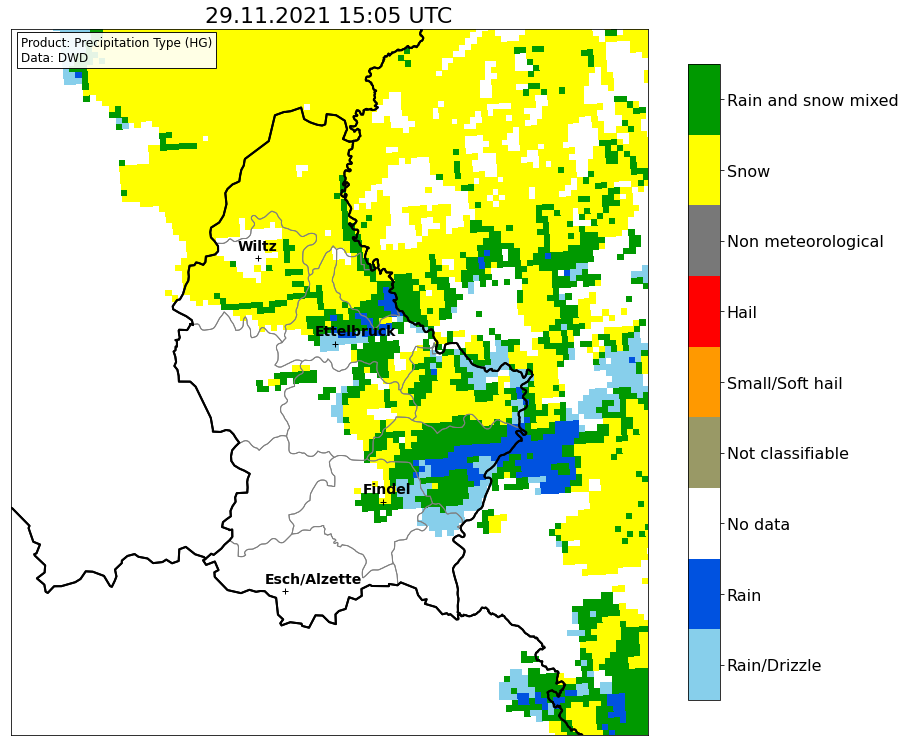

In [6]:
def plot_borders2(ax):
    filename = wrl.util.get_wradlib_data_file('geo/gadm36_LUX_0.shp')
    filename3 = wrl.util.get_wradlib_data_file('geo/gadm36_BEL_0.shp')
    filename4 = wrl.util.get_wradlib_data_file('geo/gadm36_FRA_0.shp')
    filename5 = wrl.util.get_wradlib_data_file('geo/gadm36_DEU_0.shp')
    dataset, inLayer = wrl.io.open_vector(filename)
    dataset3, inLayer3 = wrl.io.open_vector(filename3)
    dataset4, inLayer4 = wrl.io.open_vector(filename4)
    dataset5, inLayer5 = wrl.io.open_vector(filename5)
    borders, keys = wrl.georef.get_vector_coordinates(inLayer,dest_srs=proj_wgs)
    borders3, keys3 = wrl.georef.get_vector_coordinates(inLayer3,dest_srs=proj_wgs)
    borders4, keys4 = wrl.georef.get_vector_coordinates(inLayer4,dest_srs=proj_wgs)
    borders5, keys5 = wrl.georef.get_vector_coordinates(inLayer5,dest_srs=proj_wgs)
    wrl.vis.add_lines(ax, borders, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders3, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders4, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders5, color='black', lw=2, zorder=4)
    
def plot_cant(ax):
    filename6 = wrl.util.get_wradlib_data_file('geo/gadm36_LUX_2.shp')
    dataset6, inLayer6 = wrl.io.open_vector(filename6)
    borders6, keys6 = wrl.georef.get_vector_coordinates(inLayer6,dest_srs=proj_wgs)
    wrl.vis.add_lines(ax, borders6, color='grey', lw=1, zorder=4)
    
def plot_cities(ax):
    lats = [6420338.89,6381784.16,6360130.74,6441081.99]
    lons = [679048.89,690575.69,666803.75,660124.58]
    cities = ['Ettelbruck','Findel','Esch/Alzette','Wiltz']
    for lon, lat, city in zip(lons, lats, cities):
        ax.plot(lon, lat, 'k+', zorder=5)
        ax.text(lon - 5000, lat + 2000, city, fontsize='14', fontweight='bold', 
                 color='black', zorder=5)

cmap = ctables.colortables.get_colortable('NWSReflectivity')
colors1=[(0.0, 0.9254901960784314, 0.9254901960784314), 
                    (0.00392156862745098, 0.6274509803921569, 0.9647058823529412), 
                    (0.0, 0.0, 0.9647058823529412), 
                    (0.0, 0.0, 0.9647058823529412), 
                    (0.0, 0.0, 0.9647058823529412), 
                    (0.0, 0.0, 0.9647058823529412), 
                    (1.0, 1.0, 0.0)]
colors=['#87cfeb','#0052e0','#ffffff','#999966','#ff9900','#ff0000','#787878','#ffff00','#009900']
cmap1 = ListedColormap(colors)

#newcmap = ListedColormap(cmap1(np.linspace(0, 1, 16)))
#bounds = [0.1,0.5,1,2.5,5,10,15,20,25,30,35,40,45,50]
#norm = BoundaryNorm(bounds, newcmap.N)

fig = pl.figure(figsize=(14.5,13))
ax = fig.add_subplot(111, aspect="equal")
#pm = ax.pcolormesh(lon, lat, rvdata_01, cmap=newcmap, vmin=0.1, vmax=7)
#pm2 = ax.pcolormesh(lon, lat, rvdata_5, cmap=newcmap, vmin=0.1, vmax=7)
pm = ax.pcolormesh(lon, lat, fxdata, cmap=cmap1, vmin=8, vmax=80)
cb = pl.colorbar(pm, ax=ax, shrink=0.9, ticks=(12,20,28,36,44,52,60,68,76), orientation='vertical')
cb.set_label("",fontsize=16)
cb.ax.tick_params(labelsize=16)
cb.ax.set_yticklabels(['Rain/Drizzle', 'Rain', 'No data', 'Not classifiable', 'Small/Soft hail', 'Hail', 
                       'Non meteorological','Snow','Rain and snow mixed'])
pl.xlim(0.60*1e6,0.755*1e6)
pl.ylim(6.325*1e6,6.497*1e6)
pl.xticks([])
pl.yticks([])
plot_cant(ax)
plot_borders2(ax)
plot_cities(ax)
t=pl.gcf().text(0.145, 0.845, 'Product: Precipitation Type (HG)\nData: DWD', fontsize=12)
t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='black'))
pl.title(time.strftime("%d.%m.%Y %H:%M UTC"), fontsize=22)
base_filename='dwd_hg_'
suffix='.jpeg'
latest='latest'
my_file = base_filename+time2+suffix
print(my_file)
pl.savefig(my_file, bbox_inches='tight', dpi=85)